In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class VGG13(nn.Module):
    def __init__(self, num_classes):
        super(VGG13, self).__init__()
        # convert 3 inputs to 64 outputs
        self.conv1Layer1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        # activation layer for conv1Layer1
        self.relu1Layer1 = nn.ReLU()
        # convert 64 inputs from previous to 64 outputs
        self.conv1Layer2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # activation layer for conv1Layer2
        self.relu1Layer2 = nn.ReLU()
        # Spacial dimentions are reduced using maxpool
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # convert 64 inputs to 128 outputs
        self.conv2Layer1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # activation layer for conv2Layer1
        self.relu2Layer1 = nn.ReLU()
        self.conv2Layer2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # activation layer for conv2Layer2
        self.relu2Layer2 = nn.ReLU()
        # Spacial dimentions are reduced using maxpool
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # convert 128 inputs to 256 output channels
        self.conv3Layer1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3Layer1 = nn.ReLU()
        # takes 256 inputs and gives 256 output channels
        self.conv3Layer2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3Layer2 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # takes 256 inputs and gives 412 output channels
        self.conv4Layer1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        # activation layer for conv4Layer1
        self.relu4Layer1 = nn.ReLU()
        # takes 512 inputs from output of previous layer and gives 512 output channels
        self.conv4Layer2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4Layer2 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5Layer1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5Layer1 = nn.ReLU()
        self.conv5Layer2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5Layer2 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Avg pooling to reduce the image size to required size
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        # For predicting model
        self.classifier = nn.Sequential(
            # Fully connected layer with input 512 * 7 * 7
            nn.Linear(512 * 7 * 7, 4096),
            # Relu for non linearity
            nn.ReLU(),
            # Fully connected layer with input 4096 producing output 1000
            nn.Linear(4096, 4096),
            # Relu for non linearity
            nn.ReLU(),
            # Takes 1000 inputs and produces the num_classes
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.relu1Layer1(self.conv1Layer1(x))
        x = self.relu1Layer2(self.conv1Layer2(x))
        x = self.maxpool1(x)

        x = self.relu2Layer1(self.conv2Layer1(x))
        x = self.relu2Layer2(self.conv2Layer2(x))
        x = self.maxpool2(x)

        x = self.relu3Layer1(self.conv3Layer1(x))
        x = self.relu3Layer2(self.conv3Layer2(x))
        x = self.maxpool3(x)

        x = self.relu4Layer1(self.conv4Layer1(x))
        x = self.relu4Layer2(self.conv4Layer2(x))
        x = self.maxpool4(x)

        x = self.relu5Layer1(self.conv5Layer1(x))
        x = self.relu5Layer2(self.conv5Layer2(x))
        x = self.maxpool5(x)
        # Add avg pooling
        x = self.avgpool(x)
        # Flattening input for fully connected layer
        x = torch.flatten(x, 1)
        # classifier for fully connected layer
        x = self.classifier(x)
        return x


In [18]:
# Define transformations for data augmentation and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [19]:
pwd

'/user/ssheri'

In [20]:
data = datasets.ImageFolder('/user/ssheri/train_dataset',transform=transform)

In [21]:
data.classes

['airport_terminal',
 'amusement_park',
 'aquarium',
 'art_school',
 'auditorium',
 'bathroom',
 'beach',
 'bedroom',
 'bookstore',
 'bus_station-indoor',
 'campsite',
 'chemistry_lab',
 'clothing_store',
 'coffee_shop']

In [22]:
label_counts = torch.bincount(torch.tensor(data.targets))
for label, count in zip(data.classes, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: airport_terminal, Count: 5000
Label: amusement_park, Count: 5000
Label: aquarium, Count: 5000
Label: art_school, Count: 5000
Label: auditorium, Count: 5000
Label: bathroom, Count: 5000
Label: beach, Count: 5000
Label: bedroom, Count: 5000
Label: bookstore, Count: 5000
Label: bus_station-indoor, Count: 5000
Label: campsite, Count: 5000
Label: chemistry_lab, Count: 3447
Label: clothing_store, Count: 5000
Label: coffee_shop, Count: 3385


In [23]:
from torch.utils.data import random_split, DataLoader

In [24]:
train_size = int(0.7 * len(data))
rem = len(data) - train_size
test=int(rem/2)

train_data, test_data,val_data = random_split(data, [train_size,test,test])

In [25]:
len(train_data)

46782

In [26]:
train_loader = DataLoader(train_data, batch_size=35, shuffle=True)
test_loader = DataLoader(test_data, batch_size=35, shuffle=False)
val_loader = DataLoader(val_data,batch_size = 35, shuffle = False)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
len(data.classes)

14

In [30]:
model = VGG13(num_classes=14)
print(model)

VGG13(
  (conv1Layer1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1Layer1): ReLU()
  (conv1Layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1Layer2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2Layer1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2Layer1): ReLU()
  (conv2Layer2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2Layer2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3Layer1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3Layer1): ReLU()
  (conv3Layer2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3Layer2): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4Layer1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [31]:

model = VGG13(num_classes=14).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:

num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
patience = 4
best_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    training_loss /= len(train_loader)
    train_losses.append(training_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    if val_loss<best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter = 1
    if counter == patience:
        print('early stopping occured')
        torch.save(model.state_dict(), 'resetearly.pth')
        break
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {training_loss:.4f},Train_accuracy : {train_accuracy:.4f}%, Val Loss: {val_loss:.4f}, Val_accuracy: {val_accuracy:.4f}%")

print('Finished Training')

Epoch [1/10] Train Loss: 2.2700,Train_accuracy : 22.8806%, Val Loss: 1.8954, Val_accuracy: 37.6858%
Epoch [2/10] Train Loss: 1.7782,Train_accuracy : 41.4689%, Val Loss: 1.6070, Val_accuracy: 47.4713%
Epoch [3/10] Train Loss: 1.5074,Train_accuracy : 50.4403%, Val Loss: 1.4197, Val_accuracy: 53.4763%
Epoch [4/10] Train Loss: 1.3402,Train_accuracy : 56.2203%, Val Loss: 1.3764, Val_accuracy: 54.9127%
Epoch [5/10] Train Loss: 1.2142,Train_accuracy : 60.1855%, Val Loss: 1.3016, Val_accuracy: 58.0349%
Epoch [6/10] Train Loss: 1.0951,Train_accuracy : 63.7168%, Val Loss: 1.3474, Val_accuracy: 57.7257%
Epoch [7/10] Train Loss: 0.9629,Train_accuracy : 68.0326%, Val Loss: 1.3367, Val_accuracy: 59.1521%
Epoch [8/10] Train Loss: 0.8227,Train_accuracy : 72.2329%, Val Loss: 1.4255, Val_accuracy: 57.8953%
Epoch [9/10] Train Loss: 0.6667,Train_accuracy : 77.3332%, Val Loss: 1.6461, Val_accuracy: 57.1172%
Epoch [10/10] Train Loss: 0.5385,Train_accuracy : 81.6275%, Val Loss: 1.9044, Val_accuracy: 57.0873%

In [33]:
# 6. Save the best model
torch.save(model.state_dict(), 'VGG_project.pth')

In [34]:
correct = 0
total = 0
y_true = []
y_pred = []
test_losses = []
test_accuracies = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs= inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_loss /= len(val_loader)
test_accuracy = 100 * correct / total
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print('Accuracy of the network on the test images: %d %%' % (test_accuracy))
print('Test loss is ',(test_loss))

Accuracy of the network on the test images: 56 %
Test loss is  1.8788398176120134


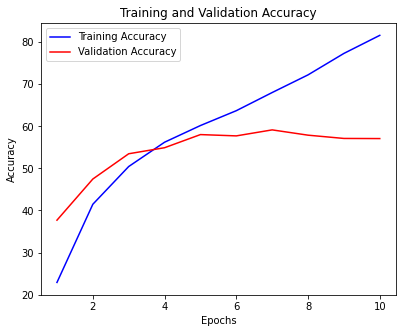

In [35]:

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


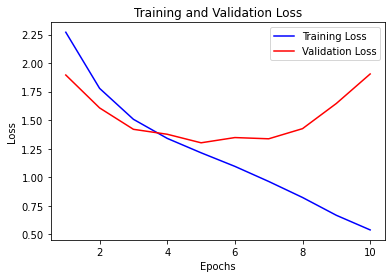

In [36]:
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

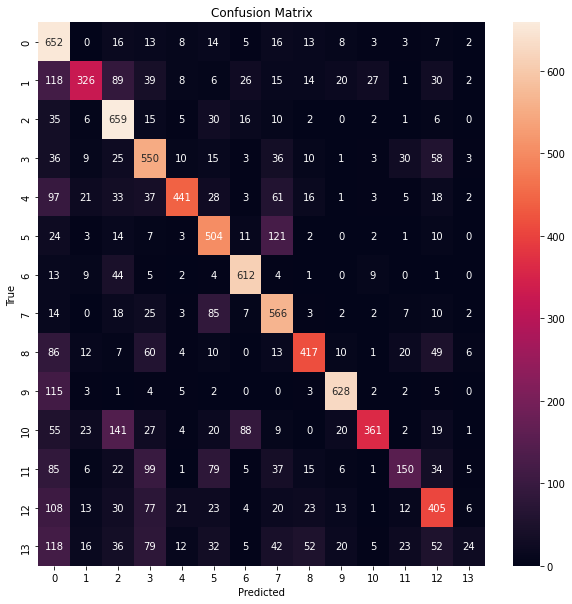

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()